In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pcb-defects:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1364422%2F2266446%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T110733Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D740aa719c030c456b588e3ede961a842cfff0f95c58f4c939793ea44dcbd9296965af820d6055ebf1a92e2a5c256e2b61d8843d8858ea3db39f28410b00ce11edabe0b6b28f1cecfe94c3784f9670c62ff91176cc6a5dc65c47a1eb1bf44aa16dff4b339e02343b3011e225bf67f6d19b9460f6de12fbbdf3928af90480b5ea8d0a1f99c1a7d24d4720495dba7481a26d1192c436e746efdaa246233df4001213c2c08b1b7869c5b61948de9d7f9173a29502117093ef45d7a49a09b8f6a5022aaa19d8e7908030a9541752548dbbe208e85a4c7055118c81cebcc56167330b27b4e7c7874e39858ea3dbc9fff2b765e8b75847f465733c97d85938bcef4a754'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2013426922 bytes downloaded
Downloaded and uncompressed: pcb-defects
Data source import complete.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 29.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Explore Dataset

In [10]:
root_dir = '/kaggle/input/pcb-defects'

In [11]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name))

/kaggle/input/pcb-defects/PCB_DATASET/PCB_USED
/kaggle/input/pcb-defects/PCB_DATASET/rotation
/kaggle/input/pcb-defects/PCB_DATASET/Annotations
/kaggle/input/pcb-defects/PCB_DATASET/images
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Missing_hole_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Spurious_copper_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Short_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Open_circuit_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Mouse_bite_rotation
/kaggle/input/pcb-defects/PCB_DATASET/rotation/Spur_rotation
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Short
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Mouse_bite
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Spur
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Missing_hole
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Spurious_copper
/kaggle/input/pcb-defects/PCB_DATASET/Annotations/Open_circuit
/kaggle/input/pcb-defects/PCB_DATASET/images/Sh

In [12]:
def count_files_in_folder(folder_path):
    files = os.listdir(folder_path)

    num_files = len(files)

    return num_files

In [13]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


# Create annotaton dataset

In [14]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    data = []

    filename = root.find('filename').text
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)

    for obj in root.findall('object'):
        name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data

In [15]:

all_data = []


for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [16]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

filename  width  height  class  xmin  ymin  xmax  ymax
0  04_short_14.jpg   3056    2464  short  1486   657  1559   737
1  04_short_14.jpg   3056    2464  short   730  1802   821  1897
2  04_short_14.jpg   3056    2464  short  1750   768  1844   881
3  05_short_10.jpg   2544    2156  short  1497   270  1580   349
4  05_short_10.jpg   2544    2156  short  1119   393  1213   467

# Visualization

In [17]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [18]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
   
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)

    image = cv2.imread(image_path)

    annotations = annot_df[annot_df['filename'] == image_name]

    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

    
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


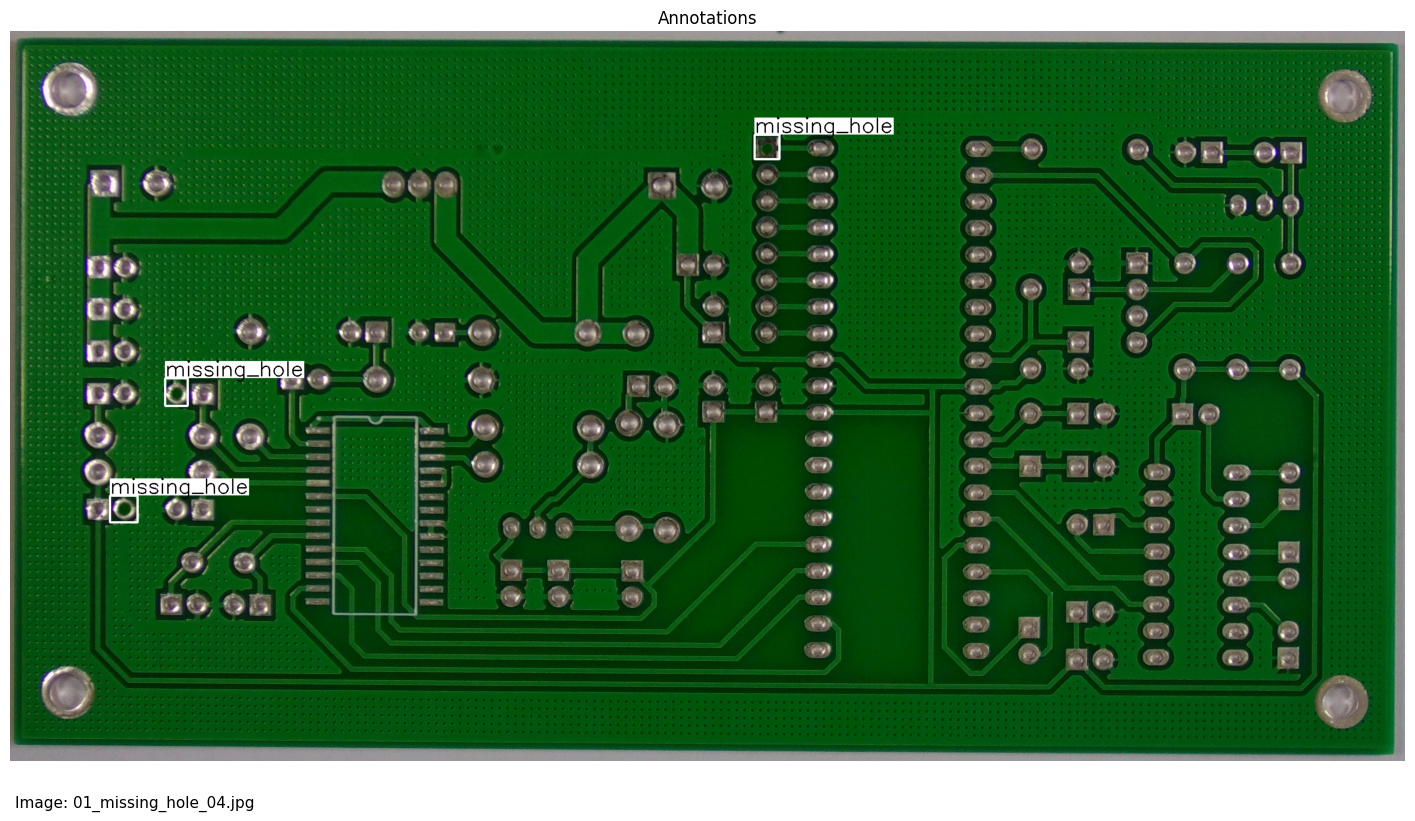

In [20]:
image_name = '01_missing_hole_04.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Dataset preprocessing

In [23]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    
    os.makedirs(output_dir, exist_ok=True)

    for root, _, files in os.walk(input_dir):
        for file in files:
            
            if file.lower().endswith(('.jpg')):
                
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                resized_image = cv2.resize(image, target_size)
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [24]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

  
    for index, row in annot_df.iterrows():

        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

filename  width  height  class  xmin  ymin  xmax  ymax
0  04_short_14.jpg    640     640  short   311   170   326   191
1  04_short_14.jpg    640     640  short   152   468   171   492
2  04_short_14.jpg    640     640  short   366   199   386   228
3  05_short_10.jpg    640     640  short   376    80   397   103
4  05_short_10.jpg    640     640  short   281   116   305   138

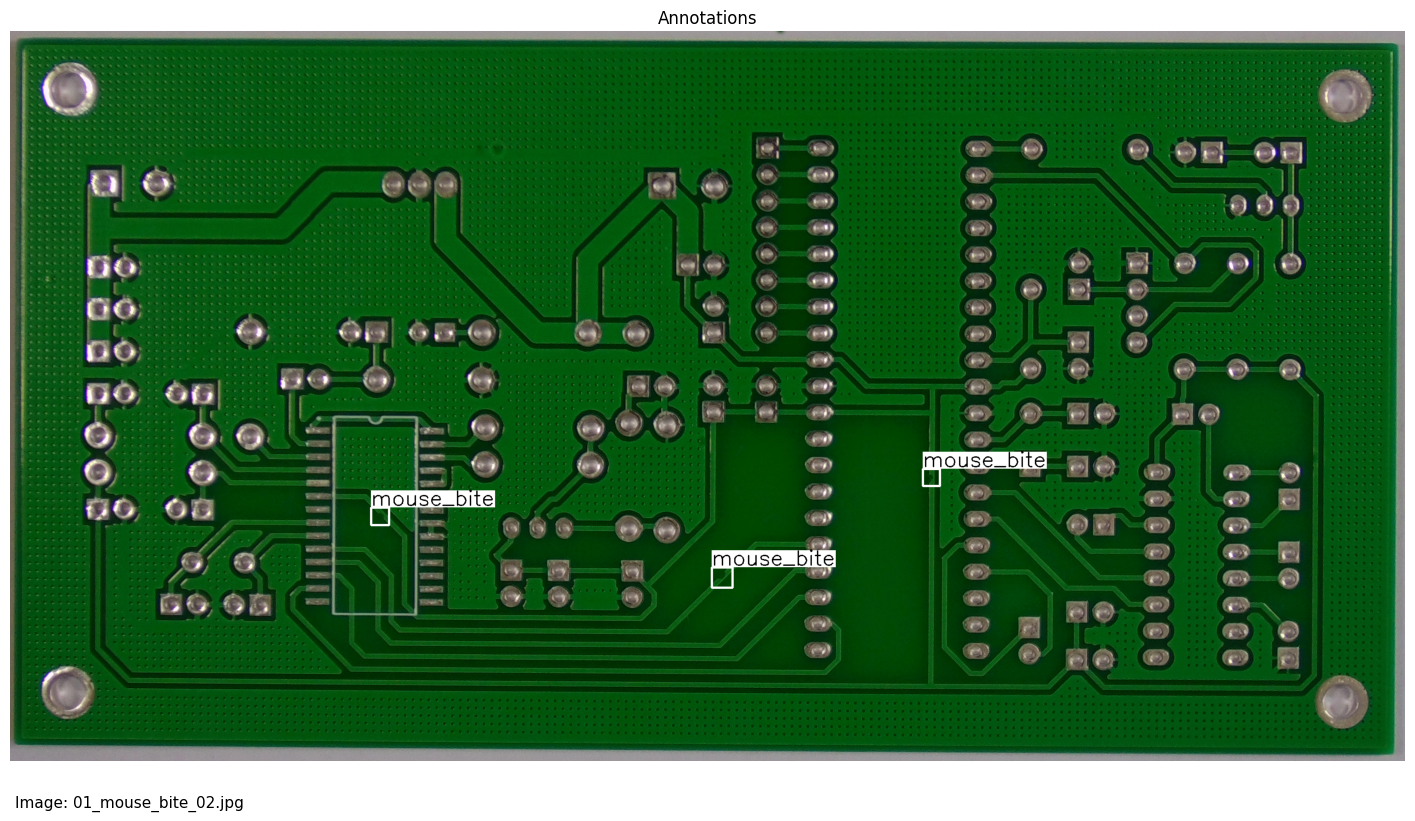

In [28]:
image_name = '01_mouse_bite_02.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Split dataset

In [21]:

output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [29]:

def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

       
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [30]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):

    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)


    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)


    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

 
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]


    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

# Model Training

# Model

In [35]:
model = YOLO('yolov8s.pt')

batch = 16
project = 'pcb'
epochs = 180
imgsz=640
save_period=1
verbose=True
mixup = 0.3

all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')

with open(data_path, 'w') as f:
    f.write(all_data_yaml)


result = model.train(data=data_path,
                  epochs=epochs,
                  batch=batch,
                  lr0=0.001,
                  lrf=0.0001,
                  imgsz=imgsz,
                  save_period=save_period,
                  verbose=verbose,
                  project=project,
                  mixup=mixup)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/input/pcb-defects/data.yaml, epochs=180, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=pcb, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=T

train: Scanning /kaggle/input/pcb-defects/PCB_DATASET/output/labels/train.cache... 658 images, 0 backgrounds, 0 corrupt: 100%|██████████| 658/658 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/pcb-defects/PCB_DATASET/output/labels/val.cache... 34 images, 0 backgrounds, 0 corrupt: 100%|██████████| 34/34 [00:00<?, ?it/s]


Plotting labels to pcb/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to pcb/train2
Starting training for 180 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/180       4.1G      3.927      16.05      1.938          8        640: 100%|██████████| 42/42 [00:20<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all         34        146      0.683     0.0321     0.0157    0.00711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/180       4.1G      2.915      3.758      1.261          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         34        146      0.215      0.306      0.139     0.0488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/180      4.05G      2.642      2.913      1.179         24        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


                   all         34        146      0.358      0.381      0.241     0.0861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/180       4.1G      2.497      2.583       1.14         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         34        146      0.441      0.562      0.455      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/180       4.1G      2.388      2.271      1.117         11        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         34        146      0.697      0.684      0.681      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/180      4.13G      2.327      2.072      1.101          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         34        146      0.765      0.665      0.738      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/180      4.07G      2.233      1.866      1.076         31        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         34        146      0.791      0.727      0.776      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/180      4.11G      2.203      1.859      1.083         11        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         34        146       0.83      0.667      0.745      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/180      4.04G      2.177      1.735      1.041          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         34        146      0.844      0.731      0.824      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/180      4.14G      2.157      1.698      1.048         13        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         34        146      0.855      0.753      0.814      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/180      3.91G      2.157      1.618      1.057         16        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         34        146        0.9      0.792      0.858      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/180      4.09G      2.138      1.664      1.053         33        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         34        146      0.838      0.774      0.805      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/180      4.09G      2.108      1.646      1.044         20        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         34        146      0.833      0.822      0.873      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/180      3.96G      2.094      1.561      1.031         16        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         34        146      0.945      0.737       0.85      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/180      3.94G      2.075      1.568      1.037         10        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


                   all         34        146      0.917      0.797      0.885       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/180      4.09G        2.1      1.557      1.026         20        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         34        146      0.846      0.802      0.882      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/180      4.08G      1.987      1.452       1.01         17        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         34        146      0.884      0.804      0.855      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/180       4.1G      2.007      1.449      1.012         17        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         34        146      0.907      0.855      0.924      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/180      4.07G      1.993      1.421      1.019          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         34        146      0.939       0.85      0.931      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/180       4.1G      1.982      1.404      1.016         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         34        146      0.941       0.84      0.908      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/180      4.07G       2.02       1.41      1.013         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         34        146      0.934      0.839      0.898      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/180       4.1G      2.003      1.461      1.011         11        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         34        146      0.935      0.849      0.929      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/180      4.12G      1.969      1.382     0.9951         24        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         34        146      0.926      0.839      0.916      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/180       4.1G      1.942      1.361      1.005          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         34        146       0.92      0.811      0.887      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/180      4.07G      1.969      1.374      1.007          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         34        146       0.89      0.873      0.909      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/180      3.93G      1.936      1.324      1.001         13        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


                   all         34        146      0.928      0.864      0.921      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/180      4.12G      1.952      1.368     0.9979          6        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         34        146      0.953       0.87      0.932      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/180      4.11G      1.931      1.326     0.9969         11        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


                   all         34        146      0.913      0.872      0.927      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/180      4.12G      1.887      1.292     0.9811         11        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         34        146      0.926      0.906      0.924       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/180       4.1G      1.934      1.339     0.9836         27        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]


                   all         34        146      0.929       0.91       0.94      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/180       4.1G      1.878      1.266     0.9831          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


                   all         34        146      0.925      0.884      0.933      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/180      4.14G        1.9      1.303     0.9933         34        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


                   all         34        146      0.896      0.901       0.94       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/180       4.1G      1.908      1.256     0.9864         20        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         34        146      0.931      0.898      0.947       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/180      4.06G      1.863      1.232     0.9823         21        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         34        146      0.927      0.882      0.937      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/180      4.12G      1.925      1.342     0.9901         14        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         34        146      0.915      0.906      0.926      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/180       4.1G      1.857      1.203     0.9714         14        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         34        146      0.929      0.883      0.928      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/180       4.1G      1.866      1.227     0.9753          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


                   all         34        146      0.927       0.89      0.937      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/180      4.12G      1.864      1.227     0.9695         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         34        146      0.882      0.905      0.923      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/180      3.95G      1.836      1.203     0.9749          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         34        146      0.911      0.908      0.919      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/180      3.96G      1.861      1.269       0.97         19        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         34        146      0.935      0.918      0.942      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/180      4.07G      1.841        1.2     0.9733         32        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         34        146      0.948      0.919       0.95      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/180       4.1G      1.804      1.151     0.9726          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         34        146      0.925      0.909      0.946      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/180      3.94G      1.827      1.198     0.9651          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         34        146      0.911       0.92      0.939       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/180      4.05G      1.809      1.165     0.9629         11        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         34        146       0.92      0.875      0.913      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/180       4.1G      1.799      1.165      0.968         19        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


                   all         34        146      0.909       0.87      0.928      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/180      4.14G      1.791      1.168     0.9625         11        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         34        146      0.952      0.909      0.946      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/180      4.12G      1.804      1.164     0.9584         16        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         34        146      0.961      0.899      0.929      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/180      4.09G      1.821      1.154     0.9559          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         34        146      0.904      0.909       0.92      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/180      4.11G      1.828      1.179       0.96         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         34        146      0.925      0.896       0.93      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/180      4.14G      1.763      1.141     0.9473         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         34        146      0.925      0.905      0.932      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/180      4.12G      1.829      1.161     0.9624          9        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         34        146      0.945      0.894      0.928      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/180      4.11G      1.761      1.122     0.9508         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         34        146      0.937      0.934      0.928      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/180      4.07G      1.809      1.149     0.9532         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         34        146      0.938      0.937      0.955      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/180      3.96G       1.78      1.124     0.9532          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         34        146      0.917      0.915       0.92      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/180      4.08G      1.756      1.121     0.9474         19        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         34        146      0.944      0.895      0.936      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/180      4.11G      1.779      1.129     0.9567         15        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         34        146      0.937      0.922      0.955      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/180      4.04G      1.759      1.103     0.9477          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         34        146      0.932       0.89      0.941      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/180      4.12G       1.81      1.168     0.9627         21        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

                   all         34        146      0.955      0.905      0.949      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/180      4.11G       1.75      1.085     0.9482          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         34        146        0.9      0.932      0.937      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/180       4.1G      1.766      1.104     0.9521         23        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         34        146      0.923      0.913      0.937      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/180      4.08G      1.724      1.081      0.941         12        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         34        146      0.946      0.885      0.955      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/180      3.93G        1.8      1.167     0.9513         28        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         34        146      0.941      0.905      0.957      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/180      3.97G      1.771      1.119     0.9381         24        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         34        146      0.923      0.914      0.954      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/180      4.12G      1.787       1.13     0.9465         28        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

                   all         34        146      0.938      0.925      0.953      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/180      3.94G      1.722      1.079     0.9446         31        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         34        146      0.933      0.934      0.948      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/180      3.92G      1.759      1.089     0.9363         13        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         34        146      0.928      0.926       0.95      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/180      4.08G      1.727      1.072     0.9403         22        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         34        146      0.943      0.923      0.953      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/180       3.9G      1.732      1.097     0.9511         23        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         34        146      0.932      0.918      0.939      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/180      4.07G      1.685      1.046     0.9364          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         34        146      0.944      0.903      0.959      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/180      3.88G      1.685      1.029     0.9372         13        640: 100%|██████████| 42/42 [00:16<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         34        146      0.945      0.909      0.949       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/180      3.88G      1.717       1.05     0.9406         15        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         34        146      0.924      0.926      0.938      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/180      4.12G      1.733       1.09     0.9482         20        640: 100%|██████████| 42/42 [00:17<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         34        146      0.939      0.915      0.954      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/180      4.05G      1.726      1.049     0.9434         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         34        146      0.939      0.907       0.95      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/180      4.11G      1.699      1.051     0.9432         10        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         34        146      0.931       0.93      0.949      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/180      3.92G      1.677      1.019      0.938         13        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         34        146      0.955      0.937       0.96      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/180      4.13G      1.686      1.025     0.9422         15        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         34        146      0.953       0.91      0.953      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/180      4.11G      1.665      1.056     0.9334          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         34        146      0.924      0.944      0.964      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/180      4.09G      1.687      1.041     0.9317         20        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         34        146       0.95      0.924      0.948      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/180      3.92G      1.695      1.048      0.937         14        640: 100%|██████████| 42/42 [00:17<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         34        146      0.937      0.927      0.956      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/180      4.14G      1.672      1.029     0.9255         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         34        146      0.938      0.924      0.943      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/180      4.07G      1.686      1.014     0.9389         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         34        146      0.944      0.934      0.961      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/180      4.13G      1.684      1.012     0.9436         21        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         34        146      0.931      0.921       0.93      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/180      4.11G      1.631     0.9835     0.9292         18        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         34        146      0.945      0.926      0.953      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/180      4.09G      1.662      1.009     0.9346         25        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         34        146      0.912      0.926      0.926      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/180       4.1G      1.658      1.022     0.9274         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         34        146      0.925      0.925      0.938      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/180       4.1G      1.655     0.9996     0.9211         27        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         34        146      0.928      0.932       0.93      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/180      4.02G      1.648      1.009     0.9248         11        640: 100%|██████████| 42/42 [00:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         34        146      0.919       0.92      0.942      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/180       4.1G      1.641     0.9791     0.9208         15        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]


                   all         34        146       0.93      0.935      0.956       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/180      4.09G      1.647     0.9877     0.9304         15        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


                   all         34        146      0.937      0.936      0.961      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/180      4.14G      1.658     0.9997     0.9283         27        640: 100%|██████████| 42/42 [00:15<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         34        146      0.937      0.917      0.938       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/180      3.92G      1.625     0.9772     0.9249         15        640: 100%|██████████| 42/42 [00:15<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         34        146      0.939       0.92      0.948      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/180         4G       1.65     0.9916     0.9305         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         34        146      0.925      0.911      0.941      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/180      4.05G      1.645     0.9893     0.9311          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         34        146      0.912      0.935      0.938      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/180      4.09G      1.635     0.9676     0.9396         23        640: 100%|██████████| 42/42 [00:15<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         34        146       0.91      0.926      0.948      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/180      4.09G      1.638     0.9948     0.9217         11        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         34        146      0.923      0.922      0.934      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/180      4.14G      1.626      1.002     0.9234         15        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


                   all         34        146      0.923      0.935      0.945      0.457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/180      3.91G      1.632     0.9957     0.9245         19        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         34        146      0.934      0.946      0.956      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/180      4.13G      1.608     0.9582     0.9153         17        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         34        146      0.944      0.935      0.954      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/180      4.07G      1.604     0.9493     0.9173          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         34        146      0.935      0.941      0.946      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/180      3.89G      1.624     0.9796     0.9214          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         34        146      0.938      0.959      0.955      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/180      4.08G      1.598     0.9817     0.9138         26        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


                   all         34        146      0.939       0.95      0.972      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/180      4.13G      1.632     0.9562     0.9243         23        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         34        146      0.939      0.956      0.965      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/180      3.92G      1.579     0.9439     0.9168         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         34        146      0.912      0.954      0.957       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/180      4.12G      1.613     0.9685     0.9218         29        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         34        146      0.917      0.916      0.946      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/180      4.12G      1.606     0.9769     0.9158          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         34        146      0.929      0.944      0.958      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/180      4.12G      1.584     0.9621      0.915         15        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         34        146      0.931      0.942      0.948      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/180      4.07G      1.578     0.9162     0.9147         19        640: 100%|██████████| 42/42 [00:16<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         34        146      0.946      0.963      0.967      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/180      3.93G      1.574     0.9336     0.9096         17        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         34        146      0.943      0.965      0.979      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/180      3.91G      1.561     0.9178     0.9043          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         34        146      0.937      0.946       0.96      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/180      4.09G      1.575     0.9258     0.9091         21        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         34        146      0.944      0.952      0.964      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/180      4.09G      1.593     0.9665     0.9183          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         34        146      0.946      0.956      0.968      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/180      4.12G      1.596     0.9498     0.9157          6        640: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         34        146      0.935      0.965      0.975      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/180      4.11G      1.586     0.9408     0.9128          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         34        146      0.942      0.954      0.958      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/180      4.06G      1.537     0.9156     0.9174         16        640: 100%|██████████| 42/42 [00:15<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         34        146      0.928      0.949       0.95      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/180      3.91G      1.575      0.938     0.9108         22        640: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         34        146      0.941      0.945      0.955      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/180      4.04G      1.625     0.9967     0.9148         20        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


                   all         34        146      0.935      0.943      0.957      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/180      4.07G      1.538     0.8991     0.9061         13        640: 100%|██████████| 42/42 [00:19<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


                   all         34        146      0.941      0.951      0.966       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/180      4.06G      1.576     0.9278     0.9054         14        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         34        146      0.931      0.962      0.973      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/180      4.11G      1.539     0.8948      0.911          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         34        146      0.946       0.97      0.969       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/180      4.14G      1.549     0.8993     0.9083         11        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         34        146       0.93      0.952      0.949      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/180      4.02G      1.574     0.9308     0.9189          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         34        146      0.943      0.954      0.975      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/180      4.12G      1.523     0.8907     0.9046         38        640: 100%|██████████| 42/42 [00:16<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         34        146       0.92      0.947      0.946       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/180      4.08G      1.543     0.9105     0.9061         36        640: 100%|██████████| 42/42 [00:16<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         34        146      0.937       0.96      0.965      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/180      3.93G      1.506     0.8713     0.9045         14        640: 100%|██████████| 42/42 [00:15<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         34        146      0.944      0.963      0.964      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/180      4.11G      1.541     0.9142     0.9055         32        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         34        146      0.944      0.965       0.97      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/180      3.94G      1.547     0.9075     0.9113         17        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         34        146      0.949      0.948      0.971       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/180      4.12G      1.537     0.9004     0.9017          7        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         34        146      0.943      0.962       0.96      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/180      4.06G       1.52      0.888     0.9055         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         34        146       0.94      0.962      0.959      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/180      4.09G      1.502     0.8714     0.9017         11        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         34        146      0.944      0.938      0.957      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/180      4.04G      1.504     0.8671     0.8943         27        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         34        146      0.938      0.953      0.954      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/180      4.03G      1.507      0.886     0.8995         24        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


                   all         34        146      0.931      0.943      0.939      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/180      4.12G      1.505     0.9046     0.9015         14        640: 100%|██████████| 42/42 [00:16<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         34        146      0.909      0.941      0.938      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/180      4.03G      1.498     0.8887     0.9039         22        640: 100%|██████████| 42/42 [00:16<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


                   all         34        146      0.934      0.964      0.972      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/180      3.95G      1.509     0.8755     0.9046         12        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


                   all         34        146      0.936      0.964      0.963       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/180      4.12G        1.5     0.8798     0.9052         24        640: 100%|██████████| 42/42 [00:16<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         34        146      0.928      0.953      0.954        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/180      4.09G      1.494     0.8689     0.8948          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         34        146      0.916      0.948      0.947      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/180      4.08G      1.479     0.8615     0.8926         11        640: 100%|██████████| 42/42 [00:15<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         34        146      0.916      0.943      0.948      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/180      4.09G       1.51     0.8819     0.9019          5        640: 100%|██████████| 42/42 [00:16<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         34        146      0.927      0.964      0.966       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/180      3.99G      1.467      0.864     0.8984         10        640: 100%|██████████| 42/42 [00:16<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


                   all         34        146       0.95      0.946      0.968      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/180      3.93G      1.461     0.8521     0.8943          8        640: 100%|██████████| 42/42 [00:16<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         34        146      0.941      0.943      0.969       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/180      4.09G      1.495     0.8691     0.9098         24        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         34        146      0.931      0.972      0.972      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/180      4.11G      1.436     0.8193      0.899         16        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         34        146      0.931      0.962      0.968      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/180      4.04G      1.468     0.8859     0.9105         13        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         34        146      0.929      0.969      0.961      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/180      4.13G      1.462     0.8471     0.8958          5        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


                   all         34        146      0.932      0.968      0.964      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/180      4.07G      1.454     0.8324     0.8989         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         34        146       0.93      0.959      0.966      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/180      4.09G      1.425     0.8156     0.8908          4        640: 100%|██████████| 42/42 [00:16<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         34        146       0.93      0.934      0.943      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/180      4.11G      1.472     0.8578     0.8924         23        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         34        146      0.918      0.923      0.927      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/180      4.09G      1.454     0.8611     0.9028          3        640: 100%|██████████| 42/42 [00:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         34        146      0.909      0.948      0.935      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/180      4.07G      1.439     0.8245     0.8984         15        640: 100%|██████████| 42/42 [00:17<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         34        146      0.916      0.957      0.951       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/180      4.12G      1.435     0.8319     0.8913         15        640: 100%|██████████| 42/42 [00:17<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         34        146      0.913      0.957      0.955      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/180      4.11G      1.449     0.8561     0.8968         13        640: 100%|██████████| 42/42 [00:18<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         34        146      0.927      0.958      0.952      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/180      4.09G       1.45      0.851     0.8924          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         34        146      0.945      0.963      0.962      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/180      4.06G      1.413      0.815      0.895         10        640: 100%|██████████| 42/42 [00:17<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         34        146      0.936      0.946      0.959      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/180       4.1G      1.419     0.8214     0.8895          2        640: 100%|██████████| 42/42 [00:17<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         34        146      0.937      0.936       0.96      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/180      4.07G      1.428     0.8213     0.8986          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         34        146      0.933      0.935      0.956      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/180       4.1G      1.435     0.8223     0.8867         18        640: 100%|██████████| 42/42 [00:16<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         34        146      0.921      0.955      0.955      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/180      3.93G      1.413     0.8302      0.896         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         34        146      0.922      0.961       0.95      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/180      4.06G       1.43     0.8242     0.8949          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         34        146      0.919      0.962       0.95       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/180      4.09G      1.409     0.8316     0.8878         11        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         34        146      0.924      0.963      0.957      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/180      3.93G      1.369     0.8039     0.8817          3        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         34        146      0.933      0.962      0.958      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/180      4.08G      1.397     0.8082      0.883         14        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         34        146      0.937      0.971      0.962      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/180      3.94G      1.401     0.8463     0.8805          7        640: 100%|██████████| 42/42 [00:17<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         34        146      0.931       0.97      0.966      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/180      4.07G      1.407     0.8274     0.8874         13        640: 100%|██████████| 42/42 [00:18<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         34        146      0.922      0.959      0.954      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/180      4.09G      1.411     0.8503      0.892         13        640: 100%|██████████| 42/42 [00:17<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         34        146      0.935      0.968      0.966      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/180      4.07G      1.418     0.8066      0.887         10        640: 100%|██████████| 42/42 [00:18<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         34        146      0.934      0.969      0.968      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/180      3.93G      1.346      0.774     0.8707         17        640: 100%|██████████| 42/42 [00:17<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         34        146      0.924      0.958      0.953      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/180      4.07G      1.399     0.8059     0.8876         18        640: 100%|██████████| 42/42 [00:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         34        146       0.93      0.972      0.966      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/180      3.94G      1.391     0.8142     0.8888         16        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         34        146      0.942      0.957      0.967      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/180      4.04G      1.373     0.8006      0.885          8        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         34        146      0.936      0.966      0.968      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/180      4.09G      1.384     0.7984     0.8832         14        640: 100%|██████████| 42/42 [00:17<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         34        146      0.932      0.968      0.965      0.487


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/180      4.07G      1.144     0.5463     0.8567          6        640: 100%|██████████| 42/42 [00:17<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         34        146       0.93      0.974       0.97      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/180      4.07G      1.144     0.5419     0.8555          9        640: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         34        146       0.92       0.96      0.959      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/180       3.9G      1.137     0.5446     0.8539          7        640: 100%|██████████| 42/42 [00:14<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]


                   all         34        146      0.918      0.966      0.959      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/180      3.91G      1.127      0.532     0.8527         10        640: 100%|██████████| 42/42 [00:13<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         34        146      0.918      0.968      0.959       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/180      4.06G      1.126     0.5566     0.8524         10        640: 100%|██████████| 42/42 [00:12<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         34        146      0.914      0.959      0.953      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/180      4.07G      1.099     0.5192     0.8471         10        640: 100%|██████████| 42/42 [00:13<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

                   all         34        146      0.917      0.958      0.953       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/180      4.05G      1.093     0.5262     0.8532          8        640: 100%|██████████| 42/42 [00:15<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         34        146      0.922      0.955      0.954       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/180      4.07G      1.098     0.5184     0.8561          5        640: 100%|██████████| 42/42 [00:15<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         34        146      0.925      0.953      0.953      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/180      4.07G      1.106     0.5182     0.8492          7        640: 100%|██████████| 42/42 [00:15<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         34        146      0.929      0.946      0.954      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/180      3.91G       1.11     0.5154     0.8523          7        640: 100%|██████████| 42/42 [00:13<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         34        146      0.929      0.946      0.954      0.475



180 epochs completed in 0.958 hours.
Optimizer stripped from pcb/train2/weights/last.pt, 22.5MB
Optimizer stripped from pcb/train2/weights/best.pt, 22.5MB

Validating pcb/train2/weights/best.pt...
Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]


                   all         34        146      0.935      0.965      0.975      0.504
          missing_hole          5         26      0.966          1      0.995      0.537
            mouse_bite          8         38      0.906      0.947      0.975      0.558
          open_circuit          6         24      0.956      0.906      0.971      0.441
                 short          5         18      0.841      0.944      0.959      0.515
                  spur          5         23          1      0.999      0.995       0.52
       spurious_copper          5         17      0.944      0.991      0.956      0.454
Speed: 0.4ms preprocess, 5.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to pcb/train2


In [47]:
model.save("PCB defect detection with YOLOv8.pt")

In [46]:
model.export()

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

PyTorch: starting from 'pcb/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (21.5 MB)

TorchScript: starting export with torch 2.4.1+cu121...
TorchScript: export success ✅ 4.6s, saved as 'pcb/train2/weights/best.torchscript' (42.9 MB)

Export complete (9.3s)
Results saved to /content/pcb/train2/weights
Predict:         yolo predict task=detect model=pcb/train2/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=pcb/train2/weights/best.torchscript imgsz=640 data=/kaggle/input/pcb-defects/data.yaml  
Visualize:       https://netron.app


'pcb/train2/weights/best.torchscript'